01_EDA_preprocessing_01dataset.ipynb

# Preprocessing and EDA on 01 Fire Dataset

Rodrigo Becerra Carrillo

https://github.com/bcrodrigo

## Introduction
In this notebook, I'll perform preprocessing and EDA on the following dataset

- `01_fire_dataset` 

**Source:** https://www.kaggle.com/datasets/phylake1337/fire-dataset

## Directory Structure

It is assumed that the directory structure for this dataset is organized as follows
```bash
.
├── data_preprocessing
│   ├── 01_fire_dataset
│       ├── fire_images
│       └── non_fire_images
│
├── jupyter_notebooks/
```
where the `jupyter_notebooks/` folder contains this notebook.

## Steps
We will do the following
1. Create a dataframe listing all images, labels, channels, width and height
2. Review that all images are the correct number of channels (3) and if they have the same width and height (250 x 250)

# Define Helper Functions
Note: in the future I want jupyter to import all helper functions contained in the `src/` folder

In [1]:
import numpy as np
import pandas as pd
import os

from torchvision.io import read_image

def review_dataset(path_to_dataset,dataset_foldername,img_folders):   
    '''
    Function that creates the annotations file (.csv) for an image dataset.
    The dataset is assumed to be divided into two folders according to the labels.
    
    Parameters
    ----------
    path_to_dataset : str
        String with the path pointing to the folder containing the dataset
    dataset_foldername : str
        Name of the folder containing all images
    img_folders : list
        List with the folder names containing the images. Both folders are assumed to be inside 
        `dataset_foldername` and each position in the list is going to be mapped to a binary category
        img_folders[0] --> category 0
        img_folders[1] --> category 1
    
    Returns
    -------
    dataframe
        A dataframe contaning the list of images and their binary label
    
    '''
    assert isinstance(path_to_dataset,str),'path_to_dataset must be a string'
    assert isinstance(dataset_foldername,str),'dataset_foldername must be a string'
    assert isinstance(img_folders,list),'img_folders must be a list'
    
    Nfolders = len(img_folders)
    
    df_list = []
    
    for index in range(Nfolders):
    
        curr_folder = img_folders[index]
    
        assert isinstance(curr_folder,str),'element of img_folders must be a string'
    
        curr_path = path_to_dataset + dataset_foldername + '/' + curr_folder
    
        image_list = os.listdir(curr_path)
        labels = index * np.ones(len(image_list), dtype = int)
    
        temp_df = pd.DataFrame(columns = ['item'], data = image_list)
    
        # update each item to include the image folder 
        temp_df['item'] = temp_df['item'].apply(lambda x: curr_folder + '/' + x)
    
        # add column with labels
        temp_df['label'] = labels
    
        df_list.append(temp_df.copy())
    
    # concatenate dataframe list into a single file
    all_images_df = pd.concat(df_list, axis = 0, ignore_index = True)
    
    print('\n Created dataframe with all images\n')
    print(all_images_df.info())
    
    original_dir = os.getcwd()
    
    os.chdir(path_to_dataset + dataset_foldername)
    
    # preallocate columns for image channels and size
    all_images_df['channels'] = 0
    all_images_df['height'] = 0
    all_images_df['width'] = 0
    
    image_list = all_images_df['item'].to_list()
    
    for index,image in enumerate(image_list):

        try:
            img_shape = read_image(image).shape
        
            all_images_df.at[index,'channels'] = img_shape[0]
            all_images_df.at[index,'height'] = img_shape[1]
            all_images_df.at[index,'width'] = img_shape[2]
            
        except:
            print('issue encountered with ',image)
            continue

    os.chdir(original_dir)
    
    return all_images_df

In [2]:
from torchvision.transforms.functional import crop
from torchvision.utils import save_image
from torchvision.io import read_image

def crop_images(df_oversized,path_to_dataset,dataset_foldername,new_height,new_width):
    '''
    # helper function to crop images and save them
    # inputs
    # df with list of oversized images 
    # assumes it has the following columns: item, label, channels, height, width
    # new image size
    # path_to_dataset
    # dataset_foldername   
    
    '''
    assert isinstance(new_height,int) and isinstance(new_width,int), 'new dimensions should be integers'
    
    df_oversized['cropped_item'] = ''    
    
    original_dir = os.getcwd()
    
    os.chdir(path_to_dataset + dataset_foldername)
    
    for i in df_oversized.index:
    
        image_path_name = df_oversized.iat[i,0]
    
        extension = image_path_name[-4:]
        image_name = image_path_name[0:-4].split('/')[-1]
    
        # rename image, including path
        cropped_image_path_name = image_path_name[0:-4] + '_cropped' + extension
        
        # update dataframe
        df_oversized.at[i,'cropped_item'] = cropped_image_path_name
        
        # read image
        img = read_image(image_path_name)
        
        # crop image
        temp = crop(img,0,0,new_height,new_width)
        
        # save image -- need to normalize to the 0 to 1 interval
        save_image(temp/255,cropped_image_path_name)
    
    print(f'\nCropped all images to {new_height} x {new_width}\n')
    
    os.chdir(original_dir)
    
    return df_oversized

In [3]:
# Contains functions to visualize images and tensors

import matplotlib.pyplot as plt
from torchvision.io import read_image

def display_tensor(tensor_name,label_name = ''):
    '''Function to display an image. The image is assumed to be a PyTorch RGB tensor (3,W,H)

    Parameters
    ----------
    tensor_name : Tensor
        PyTorch image tensor

	label_name : str
        Optional string with the image label to display.

    Returns
    -------
    None

    '''
    plt.figure()
    plt.title(label_name)
    plt.imshow(tensor_name.permute(1,2,0))
    plt.show()

def display_image(image_name): 
    '''Function to display an image. The image is assumed to be a 3-channel RGB .png or .jpg

    Parameters
    ----------
    image_name : str
        String with the path pointing to the image

    Returns
    -------
    None

    '''

    img = read_image(image_name)
    plt.figure()
    plt.title(image_name)
    plt.imshow(img.permute(1,2,0))
    plt.show()

# Define Paths to Training and Testing Datasets

In [4]:
! pwd

/Users/rodrigo/Documents/BrainStation/Capstone Project/capstone_project/jupyter_notebooks


In [5]:
! ls ../data_preprocessing/01_fire_dataset/

fire_images                non_fire_images
labels_01_fire_dataset.csv


In [6]:
# paths are relative to jupyter notebook location
path_to_dataset = '../data_preprocessing/'
dataset_foldername = '01_fire_dataset'
img_folders = ['non_fire_images','fire_images']

In [8]:
# os.chdir('../../jupyter_notebooks/')

In [13]:
df = review_dataset(path_to_dataset,dataset_foldername,img_folders)


 Created dataframe with all images

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   item    999 non-null    object
 1   label   999 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 15.7+ KB
None


In [14]:
df.head()

item  label  channels  height  width
0  non_fire_images/non_fire.134.png      0         3     450    767
1  non_fire_images/non_fire.120.png      0         3     576   1024
2  non_fire_images/non_fire.108.png      0         3     634    990
3  non_fire_images/non_fire.242.png      0         3     994   1500
4   non_fire_images/non_fire.47.png      0         3     800   1200

We can see that there are 999 images in this dataset. It seems they all have different sizes. We'll take a closer look on the next section.

# Checking Number of Channels

In [15]:
df['channels'].value_counts()

channels
3    990
4      6
1      3
Name: count, dtype: int64

We can see that there are 6 images with 4 channels and 3 with 1 channel. Let's take a closer look.

In [19]:
df_wrong_channels = df.query('channels !=3').copy()
df_wrong_channels

item  label  channels  height  width
105  non_fire_images/non_fire.151.png      0         1     335    733
144  non_fire_images/non_fire.189.png      0         1     304    540
169  non_fire_images/non_fire.160.png      0         4     666   2560
209  non_fire_images/non_fire.128.png      0         4     198    300
213  non_fire_images/non_fire.116.png      0         4     283    424
306          fire_images/fire.354.png      1         4     315    560
476          fire_images/fire.309.png      1         4     365    648
972          fire_images/fire.367.png      1         4     375    650
992          fire_images/fire.548.png      1         1     547    646

In [20]:
df_wrong_channels.sort_values(by = 'channels', ascending = False, inplace = True)
df_wrong_channels.reset_index(drop = True, inplace = True)
df_wrong_channels

item  label  channels  height  width
0  non_fire_images/non_fire.160.png      0         4     666   2560
1  non_fire_images/non_fire.128.png      0         4     198    300
2  non_fire_images/non_fire.116.png      0         4     283    424
3          fire_images/fire.354.png      1         4     315    560
4          fire_images/fire.309.png      1         4     365    648
5          fire_images/fire.367.png      1         4     375    650
6  non_fire_images/non_fire.151.png      0         1     335    733
7  non_fire_images/non_fire.189.png      0         1     304    540
8          fire_images/fire.548.png      1         1     547    646

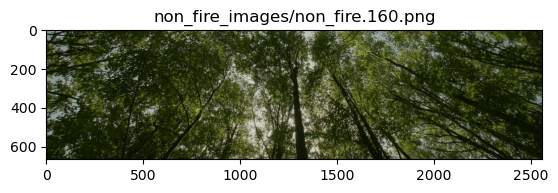

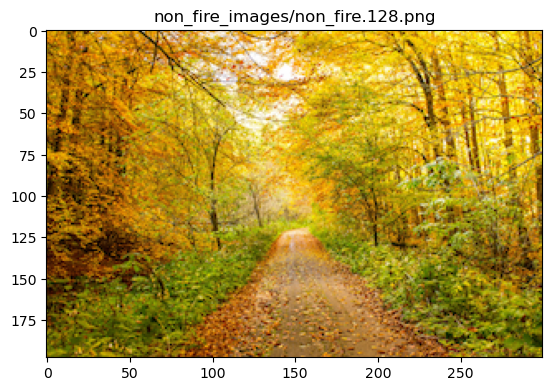

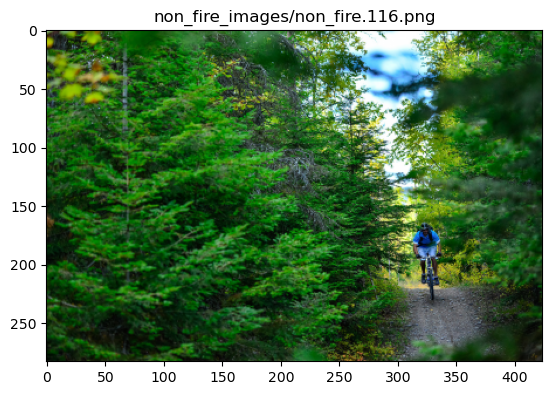

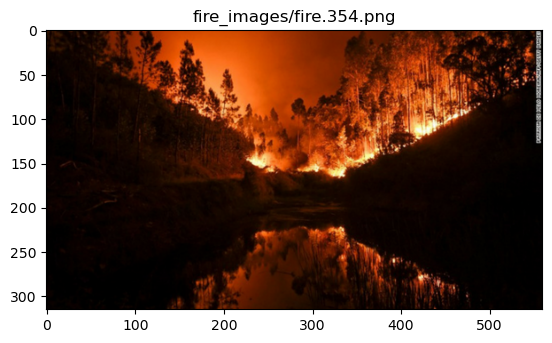

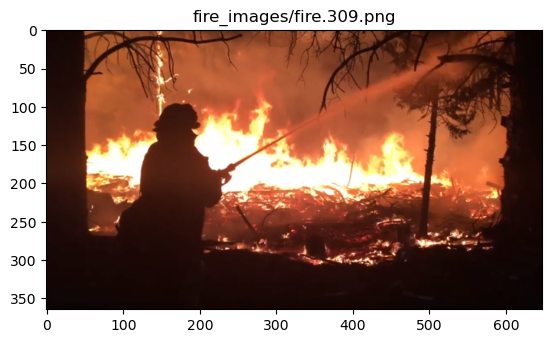

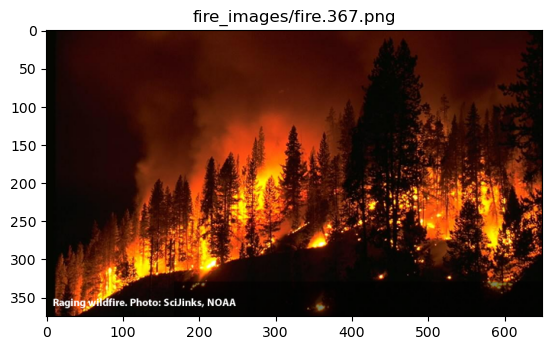

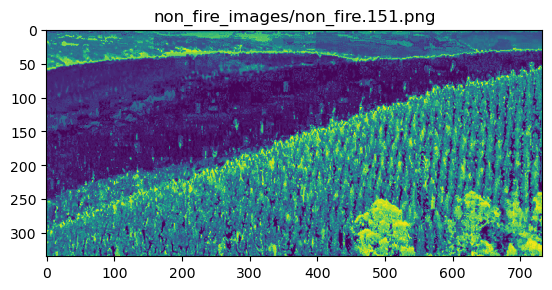

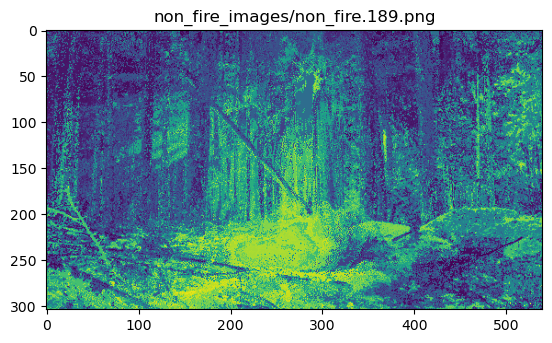

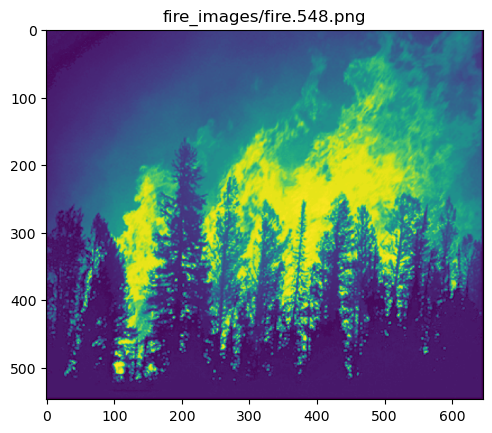

In [21]:
# change to directory containing images
curr_dir = os.getcwd()
os.chdir('../data_preprocessing/01_fire_dataset/')

for image in df_wrong_channels['item'].values:
    display_image(image)
    

os.chdir(curr_dir)

From above, we see that

- Images with 4 channels are in RGBA, where one of the channels corresponds to the transparency of the image.

- We see that the images with 1 channel have the wrong colour profile (missing RGB colours). 

For both cases we can use PIL to convert them to RGB

## Change from 1 or 4 Channels to 3 Channels (RGB)

In [31]:
! pwd

/Users/rodrigo/Documents/BrainStation/Capstone Project/capstone_project/jupyter_notebooks


In [32]:
# change to directory containing images
curr_dir = os.getcwd()
os.chdir('../data_preprocessing/01_fire_dataset/')

# for image in df_wrong_channels['item'].values:
#     display_image(image)
    

# os.chdir(curr_dir)

In [44]:
! pwd

/Users/rodrigo/Documents/BrainStation/Capstone Project/capstone_project/data_preprocessing/01_fire_dataset


In [45]:
os.chdir('../../jupyter_notebooks/')

In [65]:
# from torchvision.utils import save_image
import PIL.Image

# change to directory containing images
curr_dir = os.getcwd()
os.chdir('../data_preprocessing/01_fire_dataset/')

# add additional column
df_wrong_channels['rgb_item'] = ''

for i in df_wrong_channels.index:
       
    image = df_wrong_channels.at[i,'item']

    print(f'Converting {image} to RGB')

    original_image = PIL.Image.open(image)
    rgb_image = original_image.convert('RGB')

    extension = image[-4:]

    # get only the name of the image
    image_name = image[0:-4].split('/')[-1]

    # rename image, including path
    new_image_name = image[0:-4] + '_rgb' + extension

    # update dataframe
    df_wrong_channels.at[i,'rgb_item'] = new_image_name

    rgb_image.save(new_image_name,extension[1:])
    

# change back to current directory
os.chdir(curr_dir)

Converting non_fire_images/non_fire.160.png to RGB
Converting non_fire_images/non_fire.128.png to RGB
Converting non_fire_images/non_fire.116.png to RGB
Converting fire_images/fire.354.png to RGB
Converting fire_images/fire.309.png to RGB
Converting fire_images/fire.367.png to RGB
Converting non_fire_images/non_fire.151.png to RGB
Converting non_fire_images/non_fire.189.png to RGB
Converting fire_images/fire.548.png to RGB


In [66]:
df_wrong_channels

item  label  channels  height  width  \
0  non_fire_images/non_fire.160.png      0         4     666   2560   
1  non_fire_images/non_fire.128.png      0         4     198    300   
2  non_fire_images/non_fire.116.png      0         4     283    424   
3          fire_images/fire.354.png      1         4     315    560   
4          fire_images/fire.309.png      1         4     365    648   
5          fire_images/fire.367.png      1         4     375    650   
6  non_fire_images/non_fire.151.png      0         1     335    733   
7  non_fire_images/non_fire.189.png      0         1     304    540   
8          fire_images/fire.548.png      1         1     547    646   

                               rgb_item  
0  non_fire_images/non_fire.160_rgb.png  
1  non_fire_images/non_fire.128_rgb.png  
2  non_fire_images/non_fire.116_rgb.png  
3          fire_images/fire.354_rgb.png  
4          fire_images/fire.309_rgb.png  
5          fire_images/fire.367_rgb.png  
6  non_fire_images/non_fire.151_rgb.png  
7  non_fire_images/non_fire.189_rgb.png  
8          fire_images/fire.548_rgb.png

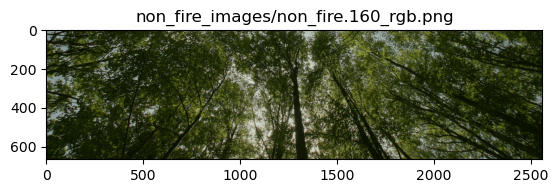

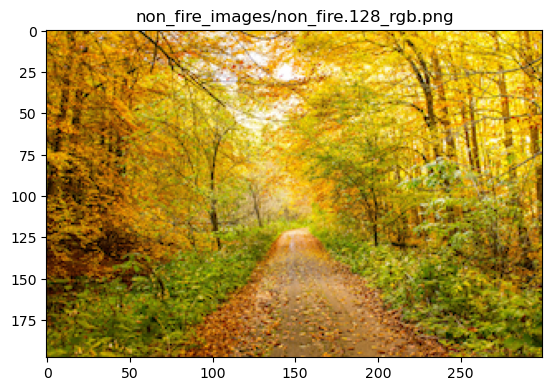

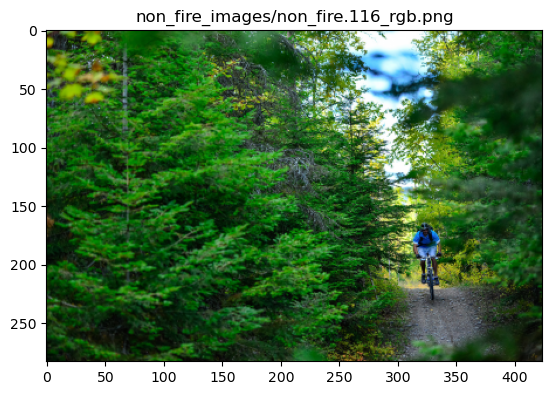

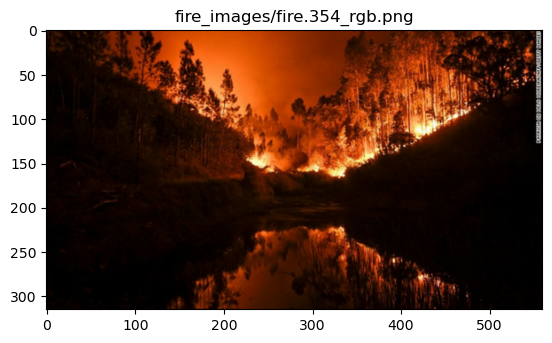

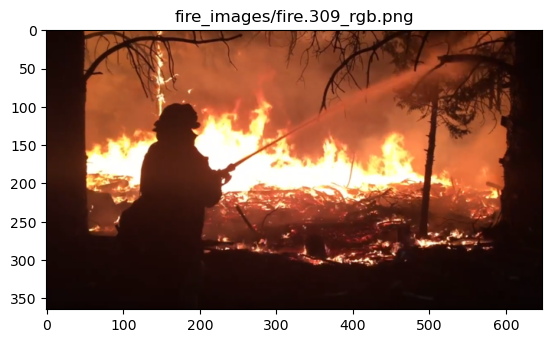

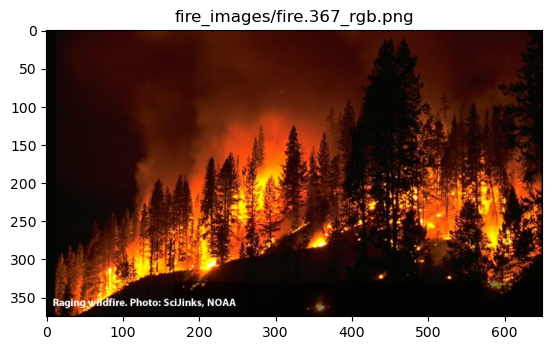

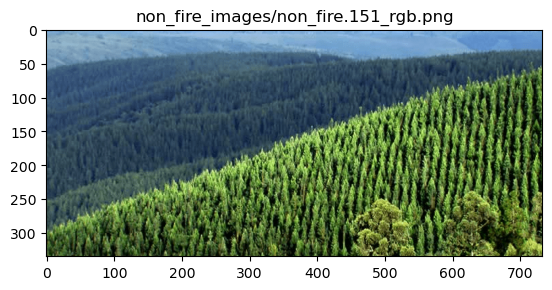

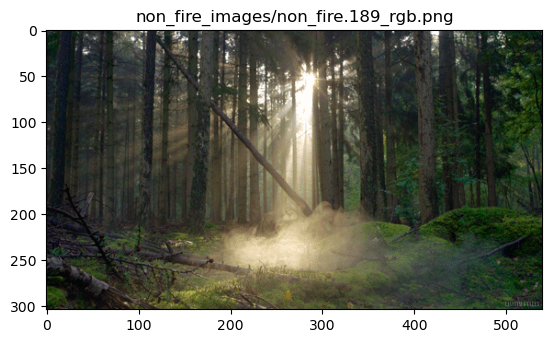

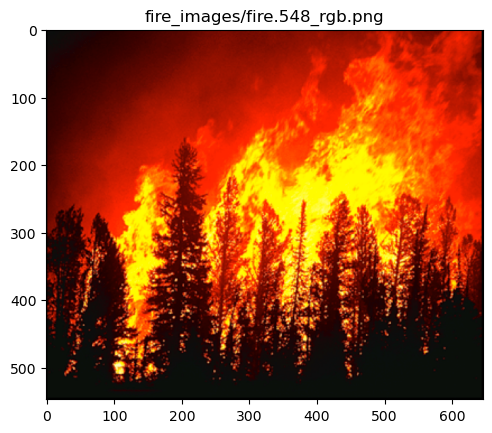

In [48]:
# Double check changes were effective

# change to directory containing images
curr_dir = os.getcwd()
os.chdir('../data_preprocessing/01_fire_dataset/')

for image in df_wrong_channels['rgb_item'].values:
    display_image(image)
    
os.chdir(curr_dir)

## Update dataframe with converted image references

In [62]:
df_correct_channels = df.query('channels == 3').copy()
df_correct_channels.reset_index(drop = True, inplace = True)
df_correct_channels

item  label  channels  height  width
0    non_fire_images/non_fire.134.png      0         3     450    767
1    non_fire_images/non_fire.120.png      0         3     576   1024
2    non_fire_images/non_fire.108.png      0         3     634    990
3    non_fire_images/non_fire.242.png      0         3     994   1500
4     non_fire_images/non_fire.47.png      0         3     800   1200
..                                ...    ...       ...     ...    ...
985          fire_images/fire.560.png      1         3     270    400
986          fire_images/fire.574.png      1         3    3082   4623
987          fire_images/fire.212.png      1         3     450    800
988           fire_images/fire.37.png      1         3    1080   1920
989           fire_images/fire.23.png      1         3     280    212

[990 rows x 5 columns]

In [73]:
df_updated_channels = df_wrong_channels[['rgb_item','label','channels','height','width']].copy()
df_updated_channels

rgb_item  label  channels  height  width
0  non_fire_images/non_fire.160_rgb.png      0         4     666   2560
1  non_fire_images/non_fire.128_rgb.png      0         4     198    300
2  non_fire_images/non_fire.116_rgb.png      0         4     283    424
3          fire_images/fire.354_rgb.png      1         4     315    560
4          fire_images/fire.309_rgb.png      1         4     365    648
5          fire_images/fire.367_rgb.png      1         4     375    650
6  non_fire_images/non_fire.151_rgb.png      0         1     335    733
7  non_fire_images/non_fire.189_rgb.png      0         1     304    540
8          fire_images/fire.548_rgb.png      1         1     547    646

In [83]:
df_updated_channels.rename(columns={'rgb_item':'item'}, inplace = True)
df_updated_channels['channels'] = 3
df_updated_channels

item  label  channels  height  width
0  non_fire_images/non_fire.160_rgb.png      0         3     666   2560
1  non_fire_images/non_fire.128_rgb.png      0         3     198    300
2  non_fire_images/non_fire.116_rgb.png      0         3     283    424
3          fire_images/fire.354_rgb.png      1         3     315    560
4          fire_images/fire.309_rgb.png      1         3     365    648
5          fire_images/fire.367_rgb.png      1         3     375    650
6  non_fire_images/non_fire.151_rgb.png      0         3     335    733
7  non_fire_images/non_fire.189_rgb.png      0         3     304    540
8          fire_images/fire.548_rgb.png      1         3     547    646

In [86]:
# concatenate dataframes
df_updated = pd.concat([df_correct_channels,df_updated_channels], axis = 0,ignore_index = True)

In [87]:
df_updated

item  label  channels  height  width
0        non_fire_images/non_fire.134.png      0         3     450    767
1        non_fire_images/non_fire.120.png      0         3     576   1024
2        non_fire_images/non_fire.108.png      0         3     634    990
3        non_fire_images/non_fire.242.png      0         3     994   1500
4         non_fire_images/non_fire.47.png      0         3     800   1200
..                                    ...    ...       ...     ...    ...
994          fire_images/fire.309_rgb.png      1         3     365    648
995          fire_images/fire.367_rgb.png      1         3     375    650
996  non_fire_images/non_fire.151_rgb.png      0         3     335    733
997  non_fire_images/non_fire.189_rgb.png      0         3     304    540
998          fire_images/fire.548_rgb.png      1         3     547    646

[999 rows x 5 columns]

# Check Height and Width Distributions

In [90]:
df_updated.describe()

label  channels       height        width
count  999.000000     999.0   999.000000   999.000000
mean     0.755756       3.0   737.782783  1152.563564
std      0.429853       0.0   654.668709   963.638092
min      0.000000       3.0   147.000000   185.000000
25%      1.000000       3.0   394.500000   640.000000
50%      1.000000       3.0   534.000000   860.000000
75%      1.000000       3.0   750.500000  1200.000000
max      1.000000       3.0  4608.000000  6720.000000